# Prediksi Kelulusan Mahasiswa
---

Ikuti langkah berikut untuk mendapatkan prediksi kelulusan mahasiswa.


1.   File yang diunggah sesuai dengan contoh template berikut: https://bit.ly/template-prediksi-kelulusan
2.   Unggah file yang sudah ada lalu tunggu hingga file terunggah 100%.
3.   Tunggu hingga proses prediksi selesai dijalankan.
4.   Hasil akan muncul di bagian bawah berbentuk chart dan CSV hasil akan terunduh secara otomatis.



In [ ]:
#@title 1. Silakan unggah Data Historis mahasiswa anda disini
from google.colab import files
uploaded = files.upload()

In [2]:
#@title 2. Masukkan batas nilai akhir kelulusan
cutting_score = int(input())

40


In [6]:
#@title 3. Proses Prediksi
import operator

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

class FuzzyKNN(BaseEstimator, ClassifierMixin):
  def __init__(self, k=3, plot=False):
    self.k = k
    self.plot = plot


  def fit(self, X, y=None):
    self._check_params(X,y)
    self.X = X
    self.y = y

    self.xdim = len(self.X[0])
    self.n = len(y)

    classes = list(set(y))
    classes.sort()
    self.classes = classes

    self.df = pd.DataFrame(self.X)
    self.df['y'] = self.y

    self.memberships = self._compute_memberships()

    self.df['membership'] = self.memberships

    self.fitted_ = True
    return self


  def predict(self, X):
    if self.fitted_ == None:
      raise Exception('predict() called before fit()')
    else:
      m = 2
      y_pred = []

      for x in X:
        neighbors = self._find_k_nearest_neighbors(pd.DataFrame.copy(self.df), x)

        votes = {}
        for c in self.classes:
          den = 0
          for n in range(self.k):
            dist = np.linalg.norm(x - neighbors.iloc[n,0:self.xdim])
            den += 1 / (dist ** (2 / (m-1)))

          neighbors_votes = []
          for n in range(self.k):
            dist = np.linalg.norm(x - neighbors.iloc[n,0:self.xdim])
            num = (neighbors.iloc[n].membership[c]) / (dist ** (2 / (m-1)))

            vote = num/den
            neighbors_votes.append(vote)
          votes[c] = np.sum(neighbors_votes)

        pred = max(votes.items(), key=operator.itemgetter(1))[0]
        y_pred.append((pred, votes))

      return y_pred


  def score(self, X, y):
    if self.fitted_ == None:
      raise Exception('score() called before fit()')
    else:
      predictions = self.predict(X)
      y_pred = [t[0] for t in predictions]
      confidences = [t[1] for t in predictions]

      return accuracy_score(y_pred=y_pred, y_true=y)


  def _find_k_nearest_neighbors(self, df, x):
    X = df.iloc[:,0:self.xdim].values

    df['distances'] = [np.linalg.norm(X[i] - x) for i in range(self.n)]

    df.sort_values(by='distances', ascending=True, inplace=True)
    neighbors = df.iloc[0:self.k]

    return neighbors


  def _find_k_nearest_neighbors_training(self, df, x):
    X = df.iloc[:,0:self.xdim].values

    df['distances'] = [np.linalg.norm(X[i] - x) for i in range(self.n)]

    df.sort_values(by='distances', ascending=True, inplace=True)
    neighbors = df.iloc[1:(self.k+1)]

    return neighbors


  def _get_counts(self, neighbors):
    groups = neighbors.groupby('y')
    counts = {group[1]['y'].iloc[0]:group[1].count()[0] for group in groups}

    return counts


  def _compute_memberships(self):
    memberships = []
    for i in range(self.n):
      x = self.X[i]
      y = self.y[i]

      neighbors = self._find_k_nearest_neighbors_training(pd.DataFrame.copy(self.df), x)
      counts = self._get_counts(neighbors)

      membership = dict()
      for c in self.classes:
        try:
          uci = 0.49 * (counts[c] / self.k)
          if c == y:
            uci += 0.51
          membership[c] = uci
        except:
          if c == y:
            membership[c] = 0.51
          elif c != y:
            membership[c] = 0

      memberships.append(membership)
    return memberships


  def _check_params(self, X, y):
    if type(self.k) != int:
      raise Exception('"k" should have type int')
    if self.k >= len(y):
      raise Exception('"k" should be less than no of feature sets')
    if self.k % 2 == 0:
      raise Exception('"k" should be odd')

    if type(self.plot) != bool:
      raise Exception('"plot" should have type bool')

# df = pd.read_excel(r'/content/Data LMS + Nilai - ICEI Rev 21.03.2021 (1).xlsx')
df = pd.read_excel(r'content/Data-LMS-+-Nilai---ICEI-Rev-21.03.2021-(1).xlsx')

#Active or Observers
df.loc[df['Nilai_Akhir'] > 0,'is_active'] = "Active"
df.loc[df['Nilai_Akhir'] == 0,'is_active'] = "Observers"
active = df.loc[df['is_active']=='Active']
observers = df.loc[df['is_active']=='Observers']

#Pass or Not (to predict)
active.loc[(active['Nilai_Akhir'])>=cutting_score, 'is_pass']="Lulus"
active.loc[(active['Nilai_Akhir'])<cutting_score, 'is_pass']="Tidak Lulus"
df1 = pd.get_dummies(active['is_pass'], prefix='Status')
df2 = pd.concat([active, df1], axis=1)

df2['Mean_kuis'] = (df2['Kuis_1']+df2['Kuis_2'])/2
#df2['Mean_tugas'] = (df2['Tugas_1']+df2['Tugas_2'])/2

X = df2[['Akses_File','Akses_Video','Akses Forum', 'Mean_kuis', 'Tugas_1']]

#Normalisasi Data Untuk X1
minmax_scaler = preprocessing.MinMaxScaler()
X_minmax = minmax_scaler.fit_transform(X)

df3 = pd.DataFrame()
df3 = df2
df3[['Akses_File_norm','Akses_Video_norm','Akses_Forum_norm', 'Mean_kuis_norm','Mean_tugas_norm']] = X_minmax

#Melakukan pengacakan pada data
df4 = df3.sample(frac=1.0, random_state=0)

#Menghapus duplikasi data
df4.drop_duplicates(subset=['Akses_File_norm','Akses_Video_norm',
                            'Akses_Forum_norm','Mean_kuis_norm', 'Mean_tugas_norm'], keep='first', inplace=True)

#X_norm_plus_name =df4[['NIM','NAMA MAHASISWA','5M_norm','NILAI RATA-RATA 5 PARTISIPASI_norm','5FD_norm','NILAI RATA-RATA 5 DISKUSI_norm','NILAI TUGAS 1_norm']]
X_norm_plus_name =df4[['Nama']]

#Memilih variabel bebas dan target
X_norm =df4[['Akses_File_norm','Akses_Video_norm','Akses_Forum_norm','Mean_kuis_norm', 'Mean_tugas_norm']]
y = df4['Status_Lulus']

from sklearn.model_selection import cross_val_score, KFold
import math

kf_plus_name = KFold(n_splits=5)

train_cv_plus_name = []
test_cv_plus_name = []
for train, test in kf_plus_name.split(X_norm_plus_name):
  train_cv_plus_name.append(train)
  test_cv_plus_name.append(test)

n_plus_name=len(X_norm_plus_name)

fold1_plus_name = math.ceil(0.2*n_plus_name)
fold2_plus_name = math.ceil(0.4*n_plus_name)
fold3_plus_name = math.ceil(0.6*n_plus_name)
fold4_plus_name = math.ceil(0.8*n_plus_name)
fold5_plus_name = n_plus_name

#test
X_train_cv1_plus_name = X_norm_plus_name[fold1_plus_name:n_plus_name]
X_test_cv1_plus_name = X_norm_plus_name[test_cv_plus_name[0][0]:fold1_plus_name]
y_train_cv1 = y[fold1_plus_name:n_plus_name]
y_test_cv1 = y[test_cv_plus_name[0][0]:fold1_plus_name]

X_train_cv2_plus_name = pd.concat([X_norm_plus_name[train_cv_plus_name[1][0]:fold1_plus_name], X_norm_plus_name[fold2_plus_name:n_plus_name]])
X_test_cv2_plus_name = X_norm_plus_name[fold1_plus_name:fold2_plus_name]
y_train_cv2 = pd.concat([y[train_cv_plus_name[1][0]:fold1_plus_name], y[fold2_plus_name:n_plus_name]])
y_test_cv2 = y[fold1_plus_name:fold2_plus_name]

X_train_cv3_plus_name = pd.concat([X_norm_plus_name[train_cv_plus_name[2][0]:fold2_plus_name], X_norm_plus_name[fold3_plus_name:n_plus_name]])
X_test_cv3_plus_name = X_norm_plus_name[fold2_plus_name:fold3_plus_name]
y_train_cv3 = pd.concat([y[train_cv_plus_name[2][0]:fold2_plus_name], y[fold3_plus_name:n_plus_name]])
y_test_cv3 = y[fold2_plus_name:fold3_plus_name]

X_train_cv4_plus_name = pd.concat([X_norm_plus_name[train_cv_plus_name[3][0]:fold3_plus_name], X_norm_plus_name[fold4_plus_name:n_plus_name]])
X_test_cv4_plus_name = X_norm_plus_name[fold3_plus_name:fold4_plus_name]
y_train_cv4 = pd.concat([y[train_cv_plus_name[3][0]:fold3_plus_name], y[fold4_plus_name:n_plus_name]])
y_test_cv4 = y[fold3_plus_name:fold4_plus_name]

X_train_cv5_plus_name = X_norm_plus_name[train_cv_plus_name[4][0]:fold4_plus_name]
X_test_cv5_plus_name = X_norm_plus_name[fold4_plus_name:fold5_plus_name]
y_train_cv5 = y[train_cv_plus_name[4][0]:fold4_plus_name]
y_test_cv5 = y[fold4_plus_name:fold5_plus_name]

kf = KFold(n_splits=5)

train_cv = []
test_cv = []
for train, test in kf.split(X_norm):
  train_cv.append(train)
  test_cv.append(test)

n=len(X_norm)

fold1 = math.ceil(0.2*n)
fold2 = math.ceil(0.4*n)
fold3 = math.ceil(0.6*n)
fold4 = math.ceil(0.8*n)
fold5 = n

#test
X_train_cv1 = X_norm[fold1:n]
X_test_cv1 = X_norm[test_cv[0][0]:fold1]
y_train_cv1 = y[fold1:n]
y_test_cv1 = y[test_cv[0][0]:fold1]

X_train_cv2 = pd.concat([X_norm[train_cv[1][0]:fold1], X_norm[fold2:n]])
X_test_cv2 = X_norm[fold1:fold2]
y_train_cv2 = pd.concat([y[train_cv[1][0]:fold1], y[fold2:n]])
y_test_cv2 = y[fold1:fold2]

X_train_cv3 = pd.concat([X_norm[train_cv[2][0]:fold2], X_norm[fold3:n]])
X_test_cv3 = X_norm[fold2:fold3]
y_train_cv3 = pd.concat([y[train_cv[2][0]:fold2], y[fold3:n]])
y_test_cv3 = y[fold2:fold3]

X_train_cv4 = pd.concat([X_norm[train_cv[3][0]:fold3], X_norm[fold4:n]])
X_test_cv4 = X_norm[fold3:fold4]
y_train_cv4 = pd.concat([y[train_cv[3][0]:fold3], y[fold4:n]])
y_test_cv4 = y[fold3:fold4]

X_train_cv5 = X_norm[train_cv[4][0]:fold4]
X_test_cv5 = X_norm[fold4:fold5]
y_train_cv5 = y[train_cv[4][0]:fold4]
y_test_cv5 = y[fold4:fold5]

#Ubah ke dalam array
X_train_array_cv1 = np.array(X_train_cv1)
X_test_array_cv1 = np.array(X_test_cv1)
y_train_array_cv1 = np.array(y_train_cv1)
y_test_array_cv1 = np.array(y_test_cv1)

X_train_array_cv2 = np.array(X_train_cv2)
X_test_array_cv2 = np.array(X_test_cv2)
y_train_array_cv2 = np.array(y_train_cv2)
y_test_array_cv2 = np.array(y_test_cv2)

X_train_array_cv3 = np.array(X_train_cv3)
X_test_array_cv3 = np.array(X_test_cv3)
y_train_array_cv3 = np.array(y_train_cv3)
y_test_array_cv3 = np.array(y_test_cv3)

X_train_array_cv4 = np.array(X_train_cv4)
X_test_array_cv4 = np.array(X_test_cv4)
y_train_array_cv4 = np.array(y_train_cv4)
y_test_array_cv4 = np.array(y_test_cv4)

X_train_array_cv5 = np.array(X_train_cv5)
X_test_array_cv5 = np.array(X_test_cv5)
y_train_array_cv5 = np.array(y_train_cv5)
y_test_array_cv5 = np.array(y_test_cv5)

from sklearn.metrics import classification_report
for i in range(3,8,2):
  fknn = FuzzyKNN(k=i)
  fknn.fit(X_train_array_cv5, y_train_array_cv5)
  hasil_prediksi = []
  for g in range(0,len(X_test_array_cv5)):
    prediksi = fknn.predict(X_test_array_cv5[[g]])
    hasil_prediksi.append(prediksi)

  y_prediksi = []
  for h in range(0,len(hasil_prediksi)):
    z = hasil_prediksi[h][0][0]
    y_prediksi.append(z)

  #print(classification_report(y_test_array_cv5, y_prediksi, digits=4))

/Users/macbook/.pyenv/versions/3.7.13/lib/python3.7/site-packages/pandas/core/indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/Users/macbook/.pyenv/versions/3.7.13/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


/Users/macbook/.pyenv/versions/3.7.13/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


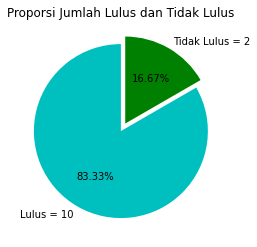

In [7]:
#@title 4. Hasil prediksi
df5 = pd.DataFrame()
df5 = X_test_cv5_plus_name
df5['PREDIKSI KELULUSAN'] = y_prediksi

lulus = sum(df5['PREDIKSI KELULUSAN'])
tidak_lulus = len(df5['PREDIKSI KELULUSAN'])-lulus


labels = 'Lulus = '+str(lulus), 'Tidak Lulus = '+str(tidak_lulus)
sections = [lulus, tidak_lulus]
colors = ['c', 'g']

plt.pie(sections, labels=labels, colors=colors,
        startangle=90,
        explode = (0, 0.1),
        autopct = '%1.2f%%')

#plt.axis('equal') # Try commenting this out.
plt.title('Proporsi Jumlah Lulus dan Tidak Lulus')
plt.show()
#print(fknn2)

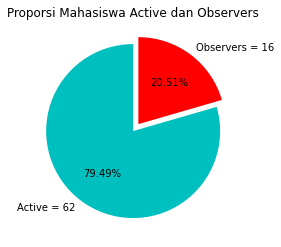

In [8]:
#@title 5. Proporsi Mahasiswa Active dan Observers
count_active = len(active)
count_observers = len(observers)


labels = 'Active = '+str(count_active), 'Observers = '+str(count_observers)
sections = [count_active, count_observers]
colors = ['c', 'r']

plt.pie(sections, labels=labels, colors=colors,
        startangle=90,
        explode = (0, 0.1),
        autopct = '%1.2f%%')

#plt.axis('equal') # Try commenting this out.
plt.title('Proporsi Mahasiswa Active dan Observers')
plt.show()

In [ ]:
#@title 6. Nilai Accuracy dan Recall 
import statistics
#Evaluasi fold 1
fknn1 = FuzzyKNN(k=3)
fknn1.fit(X_train_array_cv1, y_train_array_cv1)
hasil_prediksi1 = []
for g in range(0,len(X_test_array_cv1)):
  prediksi1 = fknn1.predict(X_test_array_cv1[[g]])
  hasil_prediksi1.append(prediksi1)

y_prediksi1 = []
for h in range(0,len(hasil_prediksi1)):
  z = hasil_prediksi1[h][0][0]
  y_prediksi1.append(z)

#Evaluasi fold 2
fknn2 = FuzzyKNN(k=3)
fknn2.fit(X_train_array_cv2, y_train_array_cv2)
hasil_prediksi2 = []
for g in range(0,len(X_test_array_cv2)):
  prediksi2 = fknn2.predict(X_test_array_cv2[[g]])
  hasil_prediksi2.append(prediksi2)

y_prediksi2 = []
for h in range(0,len(hasil_prediksi2)):
  z = hasil_prediksi2[h][0][0]
  y_prediksi2.append(z)

#Evaluasi fold 3
fknn3 = FuzzyKNN(k=3)
fknn3.fit(X_train_array_cv3, y_train_array_cv3)
hasil_prediksi3 = []
for g in range(0,len(X_test_array_cv3)):
  prediksi3 = fknn3.predict(X_test_array_cv3[[g]])
  hasil_prediksi3.append(prediksi3)

y_prediksi3 = []
for h in range(0,len(hasil_prediksi3)):
  z = hasil_prediksi3[h][0][0]
  y_prediksi3.append(z)

#Evaluasi fold 4
fknn4 = FuzzyKNN(k=3)
fknn4.fit(X_train_array_cv4, y_train_array_cv4)
hasil_prediksi4 = []
for g in range(0,len(X_test_array_cv4)):
  prediksi4 = fknn4.predict(X_test_array_cv4[[g]])
  hasil_prediksi4.append(prediksi4)

y_prediksi4 = []
for h in range(0,len(hasil_prediksi4)):
  z = hasil_prediksi4[h][0][0]
  y_prediksi4.append(z)

#Evaluasi fold 5
fknn5 = FuzzyKNN(k=3)
fknn5.fit(X_train_array_cv5, y_train_array_cv5)
hasil_prediksi5 = []
for g in range(0,len(X_test_array_cv5)):
  prediksi5 = fknn5.predict(X_test_array_cv5[[g]])
  hasil_prediksi5.append(prediksi5)

y_prediksi5 = []
for h in range(0,len(hasil_prediksi5)):
  z = hasil_prediksi5[h][0][0]
  y_prediksi5.append(z)
#print(classification_report(y_test_array_cv1, y_prediksi, digits=4))

print('Accuracy = '+str(format(statistics.mean([accuracy_score(y_test_array_cv1, y_prediksi1),accuracy_score(y_test_array_cv2, y_prediksi2),accuracy_score(y_test_array_cv3, y_prediksi3),accuracy_score(y_test_array_cv4, y_prediksi4),accuracy_score(y_test_array_cv5, y_prediksi5)]), '.4f')))
print('Recall Tidak Lulus = '+str(format(statistics.mean([recall_score(y_test_array_cv1, y_prediksi1,pos_label=0),recall_score(y_test_array_cv2, y_prediksi2, pos_label=0), recall_score(y_test_array_cv3, y_prediksi3, pos_label=0),recall_score(y_test_array_cv4, y_prediksi4,pos_label=0), recall_score(y_test_array_cv5, y_prediksi5,pos_label=0)]), '.4f')))
print('Recall Lulus = '+str(format(statistics.mean([recall_score(y_test_array_cv1, y_prediksi1,pos_label=1),recall_score(y_test_array_cv2, y_prediksi2, pos_label=1), recall_score(y_test_array_cv3, y_prediksi3, pos_label=1),recall_score(y_test_array_cv4, y_prediksi4,pos_label=1), recall_score(y_test_array_cv5, y_prediksi5,pos_label=1)]), '.4f')))
print('Precision Tidak Lulus = '+str(format(statistics.mean([precision_score(y_test_array_cv1, y_prediksi1,pos_label=0),precision_score(y_test_array_cv2, y_prediksi2, pos_label=0), precision_score(y_test_array_cv3, y_prediksi3, pos_label=0),precision_score(y_test_array_cv4, y_prediksi4,pos_label=0), precision_score(y_test_array_cv5, y_prediksi5,pos_label=0)]), '.4f')))
print('Precision Lulus = '+str(format(statistics.mean([precision_score(y_test_array_cv1, y_prediksi1,pos_label=1),precision_score(y_test_array_cv2, y_prediksi2, pos_label=1), precision_score(y_test_array_cv3, y_prediksi3, pos_label=1),precision_score(y_test_array_cv4, y_prediksi4,pos_label=1), precision_score(y_test_array_cv5, y_prediksi5,pos_label=1)]), '.4f')))
#format(0.500000000, '.2f')
#tabel_arp = print(classification_report(y_test_array_cv1, y_prediksi, digits=4))
#tabel_arp[

Accuracy = 0.9333
Recall Tidak Lulus = 0.6000
Recall Lulus = 1.0000
Precision Tidak Lulus = 0.8000
Precision Lulus = 0.9232


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [9]:
#@title 7. Silahkan unggah Data Mahasiswa yang sedang berlangsung (Ongoing)
uploaded1 = files.upload()

KeyboardInterrupt: 

In [12]:
#@title 8. Proses Prediksi Mahasiswa (Data Ongoing)
#@title
X_test_cv5_plus_name.loc[X_test_cv5_plus_name['PREDIKSI KELULUSAN']==1, 'PREDIKSI KELULUSAN']="Diprediksi Lulus"
#@title
X_test_cv5_plus_name.loc[X_test_cv5_plus_name['PREDIKSI KELULUSAN']==0, 'PREDIKSI KELULUSAN']="Diprediksi Tidak Lulus"
df6 = pd.read_excel(r'content/Contoh-Data-ICE-On-Going.xlsx')
#Pemilihan variabel independen
df6['Mean_kuis'] = (df6['Kuis_1']+df6['Kuis_2'])/2
X2 = df6[['Nama','Akses_File','Akses_Video','Akses Forum', 'Mean_kuis', 'Tugas_1']]
#Normalisasi Data
for i in range(len(X2)):
  X2.loc[i, "Akses_File_norm"] = (X2['Akses_File'][i] - X['Akses_File'].min())/(X['Akses_File'].max() - X['Akses_File'].min())
  X2.loc[i, "Akses_Video_norm"] = (X2['Akses_Video'][i] - X['Akses_Video'].min())/(X['Akses_Video'].max() - X['Akses_Video'].min())
  X2.loc[i, "Akses_Forum_norm"] = (X2['Akses Forum'][i] - X['Akses Forum'].min())/(X['Akses Forum'].max() - X['Akses Forum'].min())
  X2.loc[i, "Mean_kuis_norm"] = (X2['Mean_kuis'][i] - X['Mean_kuis'].min())/(X['Mean_kuis'].max() - X['Mean_kuis'].min())
  X2.loc[i, "Mean_tugas_norm"] = (X2['Tugas_1'][i] - X['Tugas_1'].min())/(X['Tugas_1'].max() - X['Tugas_1'].min())
#Variabel independen setelah normalisasi
X3 = X2[['Akses_File_norm','Akses_Video_norm','Akses_Forum_norm','Mean_kuis_norm','Mean_tugas_norm']]
X3 = X3.round(6)
#Mengubah Variabel independen ke dalam array
X3_array = np.array(X3)

X_norm = X_norm.round(6)

active2 = X3.loc[(X3['Mean_kuis_norm'] != 0) | (X3['Mean_tugas_norm'] != 0)]
observers2 = X3.loc[(X3['Mean_kuis_norm'] == 0) & (X3['Mean_tugas_norm'] == 0)]

#Daftar Mahasiswa yang Observers (Data Ongoing)
observers2.loc[(observers2['Mean_kuis_norm'] == 0) & (observers2['Mean_tugas_norm'] == 0),'Status'] = "Observers"
result = pd.concat([X2[['Nama']], observers2], axis=1, join='inner')

#Daftar Mahasiswa yang Active (Data Ongoing)
active2.loc[(active2['Mean_kuis_norm'] != 0) | (active2['Mean_tugas_norm'] != 0),'Status'] = "Active"
result2 = pd.concat([X2[['Nama']], active2], axis=1, join='inner')

#Mengecek apakah ada duplikasi antara data ongoing dengan data historis
duplicate = pd.merge(result2, df4[['Akses_File_norm','Akses_Video_norm','Akses_Forum_norm','Mean_kuis_norm','Mean_tugas_norm', 'is_pass']].round(6),
                     on=['Akses_File_norm','Akses_Video_norm', 'Akses_Forum_norm','Mean_kuis_norm','Mean_tugas_norm'],
                     how='inner')
duplicate.loc[duplicate['is_pass']=="Lulus", 'Status']="Diprediksi Lulus"
duplicate.loc[duplicate['is_pass']=="Tidak Lulus", 'Status']="Diprediksi Tidak Lulus"
duplicate.drop(columns=['is_pass'], inplace=True)

non_duplicate = result2.merge(X_norm, on=['Akses_File_norm','Akses_Video_norm',
                                         'Akses_Forum_norm','Mean_kuis_norm','Mean_tugas_norm'],
                         how='left', indicator=True)
non_duplicate = non_duplicate.loc[non_duplicate._merge=='left_only',non_duplicate.columns!='_merge']

X_non_duplicate = non_duplicate[['Akses_File_norm','Akses_Video_norm', 'Akses_Forum_norm','Mean_kuis_norm','Mean_tugas_norm']]
X_non_duplicate_array = np.array(X_non_duplicate)


#fold 1
fknn_new1 = FuzzyKNN(k=3)
fknn_new1.fit(X_train_array_cv1, y_train_array_cv1)
hasil_prediksi_new1 = []
for g in range(0,len(X_non_duplicate_array)):
  prediksi_new1 = fknn_new1.predict(X_non_duplicate_array[[g]])
  hasil_prediksi_new1.append(prediksi_new1)

y_prediksi_new1 = []
for h in range(0,len(hasil_prediksi_new1)):
  z = hasil_prediksi_new1[h][0][0]
 
  y_prediksi_new1.append(z)

#fold 2
fknn_new2 = FuzzyKNN(k=3)
fknn_new2.fit(X_train_array_cv2, y_train_array_cv2)
hasil_prediksi_new2 = []
for g in range(0,len(X_non_duplicate_array)):
  prediksi_new2 = fknn_new2.predict(X_non_duplicate_array[[g]])
  hasil_prediksi_new2.append(prediksi_new2)

y_prediksi_new2 = []
for h in range(0,len(hasil_prediksi_new2)):
  z = hasil_prediksi_new2[h][0][0]
 
  y_prediksi_new2.append(z)

#fold 3
fknn_new3 = FuzzyKNN(k=3)
fknn_new3.fit(X_train_array_cv3, y_train_array_cv3)
hasil_prediksi_new3 = []
for g in range(0,len(X_non_duplicate_array)):
  prediksi_new3 = fknn_new3.predict(X_non_duplicate_array[[g]])
  hasil_prediksi_new3.append(prediksi_new3)

y_prediksi_new3 = []
for h in range(0,len(hasil_prediksi_new3)):
  z = hasil_prediksi_new3[h][0][0]
 
  y_prediksi_new3.append(z)

#fold 4
fknn_new4 = FuzzyKNN(k=3)
fknn_new4.fit(X_train_array_cv4, y_train_array_cv4)
hasil_prediksi_new4 = []
for g in range(0,len(X_non_duplicate_array)):
  prediksi_new4 = fknn_new4.predict(X_non_duplicate_array[[g]])
  hasil_prediksi_new4.append(prediksi_new4)

y_prediksi_new4 = []
for h in range(0,len(hasil_prediksi_new4)):
  z = hasil_prediksi_new4[h][0][0]
 
  y_prediksi_new4.append(z)

#fold 5
fknn_new5 = FuzzyKNN(k=3)
fknn_new5.fit(X_train_array_cv5, y_train_array_cv5)
hasil_prediksi_new5 = []
for g in range(0,len(X_non_duplicate_array)):
  prediksi_new5 = fknn_new5.predict(X_non_duplicate_array[[g]])
  hasil_prediksi_new5.append(prediksi_new5)

y_prediksi_new5 = []
for h in range(0,len(hasil_prediksi_new5)):
  z = hasil_prediksi_new5[h][0][0]
 
  y_prediksi_new5.append(z)

#Menampilkan mahasiswa hasil prediksi
df8 = non_duplicate[['Nama']]
df8["Prediksi1"] = y_prediksi_new1
df8["Prediksi2"] = y_prediksi_new2
df8["Prediksi3"] = y_prediksi_new3
df8["Prediksi4"] = y_prediksi_new4
df8["Prediksi5"] = y_prediksi_new5
#Vote Hasil Prediksi
df8.loc[(df8['Prediksi1']+df8['Prediksi2']+df8['Prediksi3']+df8['Prediksi4']+df8['Prediksi5'])/5 >= 0.5,'Hasil Prediksi'] = "Diprediksi Lulus"
df8.loc[(df8['Prediksi1']+df8['Prediksi2']+df8['Prediksi3']+df8['Prediksi4']+df8['Prediksi5'])/5 < 0.5,'Hasil Prediksi'] = "Diprediksi Tidak Lulus"

#Data Gabungan
result3 = pd.concat([non_duplicate, df8[['Hasil Prediksi']]], axis=1, join='inner')
result3.drop(columns=['Status'], inplace=True)
result3.rename(columns={'Hasil Prediksi':'Status'}, inplace=True)
union = pd.concat([result, duplicate, result3], ignore_index=True)

/Users/macbook/.pyenv/versions/3.7.13/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/Users/macbook/.pyenv/versions/3.7.13/lib/python3.7/site-packages/pandas/core/indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/Users/macbook/.pyenv/versions/3.7.13/lib/python3.7/site-packages/ipykernel_launcher.py:125: SettingWithCopyWarning: 
A value is trying to be se

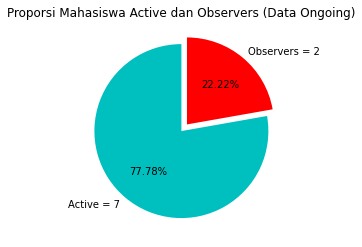

In [13]:
#@title 9. Proporsi Mahasiswa Active dan Observers (Data Ongoing)
count_active2 = len(active2)
count_observers2 = len(observers2)


labels2 = 'Active = '+str(count_active2), 'Observers = '+str(count_observers2)
sections2 = [count_active2, count_observers2]
colors2 = ['c', 'r']

plt.pie(sections2, labels=labels2, colors=colors2,
        startangle=90,
        explode = (0, 0.1),
        autopct = '%1.2f%%')

#plt.axis('equal') # Try commenting this out.
plt.title('Proporsi Mahasiswa Active dan Observers (Data Ongoing)')
plt.show()

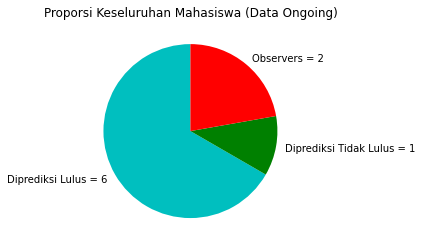

In [14]:
#@title 10. Proporsi Keseluruhan Mahasiswa (Data Ongoing)
count_lulus = len(union[union['Status']=="Diprediksi Lulus"])
count_tidaklulus = len(union[union['Status']=="Diprediksi Tidak Lulus"])
count_observer = len(union[union['Status']=="Observers"])

labels3 = 'Diprediksi Lulus = '+str(count_lulus), 'Diprediksi Tidak Lulus = '+str(count_tidaklulus), 'Observers = '+str(count_observer)
sections3 = [count_lulus, count_tidaklulus, count_observer]
colors3 = ['c', 'g', 'r']

plt.pie(sections3, labels=labels3, colors=colors3,
        startangle=90)

#plt.axis('equal') # Try commenting this out.
plt.title('Proporsi Keseluruhan Mahasiswa (Data Ongoing)')
plt.show()

In [15]:
#@title 11. Download Hasil Prediksi ke Excel
excelfilename = "Hasil Prediksi.xlsx"
union[['Nama', 'Status']].to_excel(excelfilename, sheet_name='Hasil Prediksi', index=False)
files.download(excelfilename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>